## Image In-painting with OpenVINO™
This notebook demonstrates how to use an image in-painting model with OpenVINO, using [GMCNN model](https://github.com/shepnerd/inpainting_gmcnn) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). This model, given a tampered image, is able to create something very similar to the original image. The Following pipeline will be used in this notebook.
![pipeline](https://user-images.githubusercontent.com/4547501/165792473-ba784c0d-0a37-409f-a5f6-bb1849c1d140.png)


In [1]:
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core

sys.path.append("../utils")
import notebook_utils as utils

### Download the Model
Models can be downloaded with `omz_downloader` - a command-line tool for downloading models from the Open Model Zoo. `gmcnn-places2-tf` is the omz name for the considered model. You can find the names of all available models [here](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/index.md) and [here](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/index.md). The selected model comes from the public directory, which means it must be converted into Intermediate Representation (IR). This step is skipped if the model is already downloaded.


In [2]:
# A directory where the model will be downloaded.
base_model_dir = "model"
# The name of the model from Open Model Zoo.
model_name = "gmcnn-places2-tf"

model_path = Path(f"{base_model_dir}/public/{model_name}/{model_name}/frozen_model.pb")
if not model_path.exists():
    download_command = f"omz_downloader " \
                       f"--name {model_name} " \
                       f"--output_dir {base_model_dir}"
    ! $download_command
else:
    print("Already downloaded")

################|| Downloading gmcnn-places2-tf ||################

========== Downloading model\public\gmcnn-places2-tf\gmcnn-places2-tf.zip
... 2%, 1024 KB, 191 KB/s, 5 seconds passed
... 4%, 2048 KB, 201 KB/s, 10 seconds passed
... 6%, 3072 KB, 171 KB/s, 17 seconds passed
... 9%, 4096 KB, 142 KB/s, 28 seconds passed
... 11%, 5120 KB, 142 KB/s, 35 seconds passed
... 13%, 6144 KB, 144 KB/s, 42 seconds passed
... 15%, 7168 KB, 143 KB/s, 50 seconds passed
... 18%, 8192 KB, 153 KB/s, 53 seconds passed
... 20%, 9216 KB, 148 KB/s, 62 seconds passed
... 22%, 10240 KB, 146 KB/s, 69 seconds passed
... 24%, 11264 KB, 142 KB/s, 79 seconds passed
... 27%, 12288 KB, 142 KB/s, 86 seconds passed
... 29%, 13312 KB, 145 KB/s, 91 seconds passed
... 31%, 14336 KB, 146 KB/s, 98 seconds passed
... 34%, 15360 KB, 151 KB/s, 101 seconds passed
... 36%, 16384 KB, 158 KB/s, 103 seconds passed
... 38%, 17408 KB, 166 KB/s, 104 seconds passed
... 40%, 18432 KB, 175 KB/s, 105 seconds passed
... 43%, 19456 KB, 183

### Convert Tensorflow model to OpenVINO IR format

The pre-trained model is in TensorFlow format. To use it with OpenVINO, convert it to OpenVINO IR format. To do this, use Model Converter (`omz_converter`), which is another command-line tool. Then, specify the precision for `FP32` but it can be `FP16` as well. This step is also skipped if the model is already converted.


In [3]:
precision = "FP32"
ir_path = Path(f"{base_model_dir}/public/{model_name}/{precision}/{model_name}.xml")

# Run Model Optimizer if the OpenVINO IR model file does not exist.
if not ir_path.exists():
    print("Exporting TensorFlow model to IR... This may take a few minutes.")
    convert_command = f"omz_converter " \
                      f"--name {model_name} " \
                      f"--download_dir {base_model_dir} " \
                      f"--precisions {precision}"
    ! $convert_command
else:
    print("IR model already exists.")

Exporting TensorFlow model to IR... This may take a few minutes.
========== Converting gmcnn-places2-tf to IR (FP32)
Conversion command: C:\Users\97798\openvino_en\Scripts\python.exe -- C:\Users\97798\openvino_en\Scripts\mo.exe --framework=tf --data_type=FP32 --output_dir=model\public\gmcnn-places2-tf\FP32 --model_name=gmcnn-places2-tf --input=Placeholder,Placeholder_1 --input_model=model\public\gmcnn-places2-tf/gmcnn-places2-tf/frozen_model.pb --output=Minimum --layout=Placeholder(NHWC),Placeholder_1(NHWC) "--input_shape=[1, 512, 680, 3],[1, 512, 680, 1]"

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	C:\Users\97798\openvino_en\Scripts\model\public\gmcnn-places2-tf/gmcnn-places2-tf/frozen_model.pb
	- Path for generated IR: 	C:\Users\97798\openvino_en\Scripts\model\public\gmcnn-places2-tf\FP32
	- IR output name: 	gmcnn-places2-tf
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Placeholder,Placeholder_1
	- Output lay

### Load the model

Now, load the OpenVINO IR model and perform as follows:

 1. Initialize OpenVINO Runtime (Core).
 2. Read the network from `*.bin` and `*.xml` files (weights and architecture)
 3. Compile the model for the "CPU".
 4. Get input and output nodes.

Only a few lines of code are required to run the model:

In [4]:
core = Core()

# Read the model.xml and weights file
model = core.read_model(model=ir_path)
# Load the model on to the CPU
compiled_model = core.compile_model(model=model, device_name="CPU")
# Store the input and output nodes
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

### Determine the input shapes of the model

Note that both input shapes are the same. However, the second input has 1 channel (monotone).

In [5]:
N, H, W, C = input_layer.shape

### Create a square mask

Next, create a single channeled mask that will be laid on top of the original image.

In [6]:
def create_mask(image_width, image_height, size_x=30, size_y=30, number=1):
    """
    Create a square mask of defined size on a random location.

    :param: image_width: width of the image
    :param: image_height: height of the image
    :param: size: size in pixels of one side
    :returns:
            mask: grayscale float32 mask of size shaped [image_height, image_width, 1]
    """

    mask = np.zeros((image_height, image_width, 1), dtype=np.float32)
    for _ in range(number):
        start_x = np.random.randint(image_width - size_x)
        start_y = np.random.randint(image_height - size_y)
        cv2.rectangle(img=mask,
                      pt1=(start_x, start_y),
                      pt2=(start_x + size_x, start_y + size_y),
                      color=(1, 1, 1),
                      thickness=cv2.FILLED)
    return mask

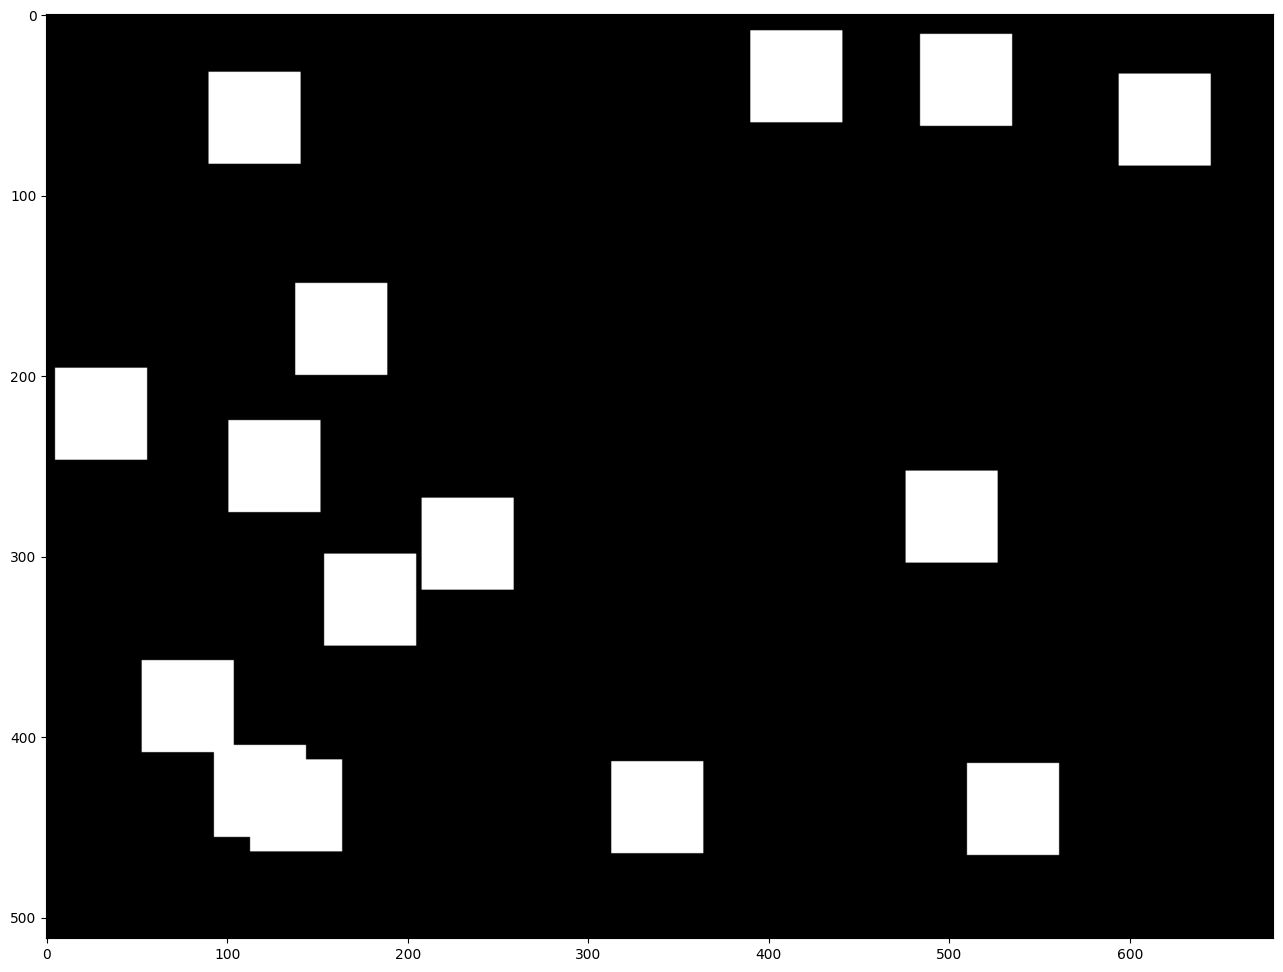

In [7]:
# Generate a square mask of size WxH with number of "holes".
mask = create_mask(image_width=W, image_height=H, size_x=50, size_y=50, number=15)
# This mask will be laid over the input image as noise.
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB));

### Load and Resize the Image

This image will be altered by using the mask. You can process any image you like. Just change the URL below.

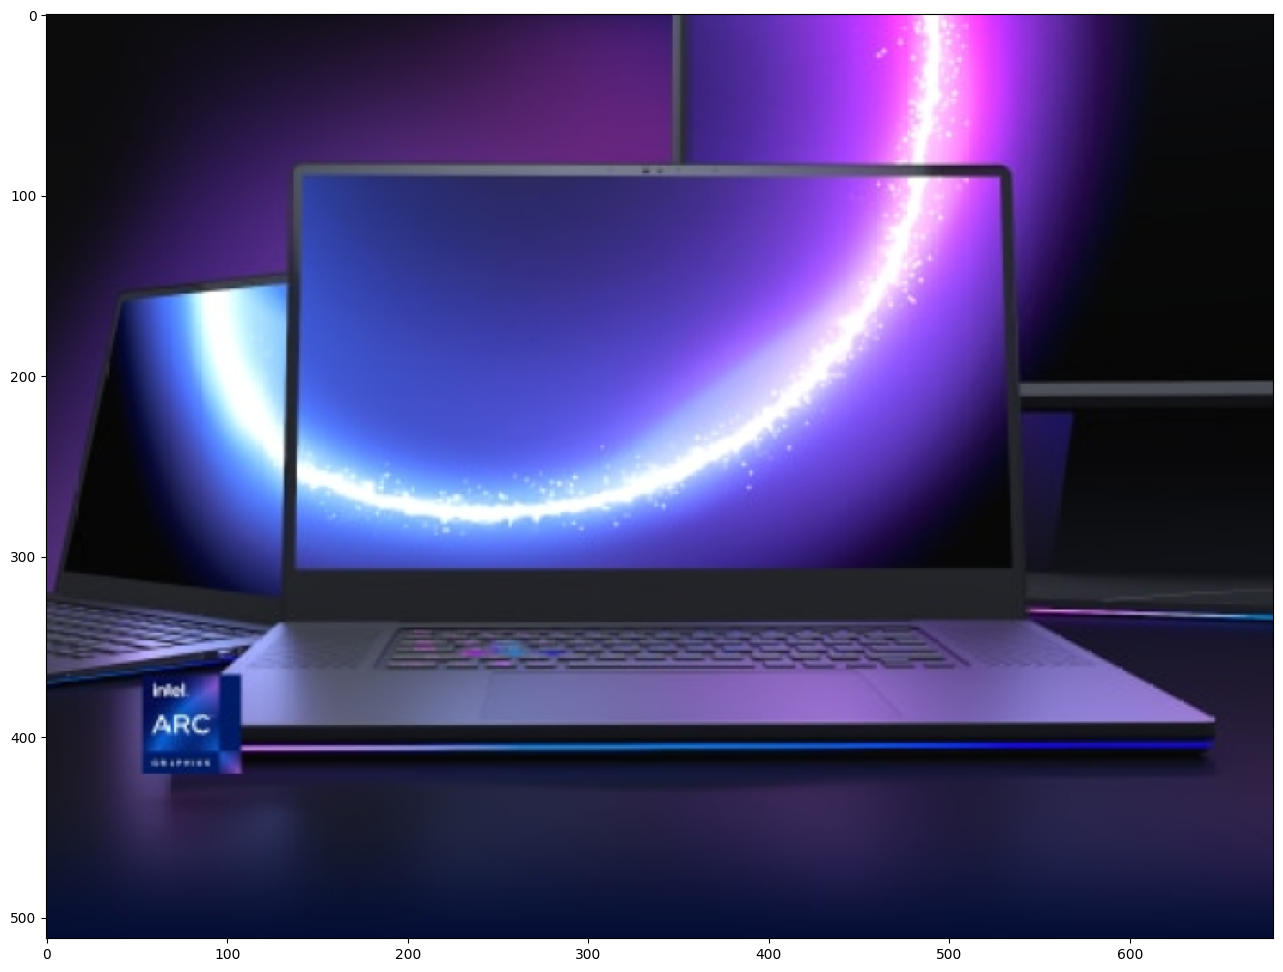

In [8]:
# Download an image.
url = "https://www.intel.com/content/dam/www/central-libraries/us/en/images/arc-home-hero-128.png.rendition.intel.web.480.360.png"
image_file = utils.download_file(
    url, filename="laptop.png", directory="data", show_progress=False, silent=True, timeout=30
)
assert Path(image_file).exists()

# Read the image.
image = cv2.imread("data/laptop.png")
# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(src=image, dsize=(W, H), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB));

### Generating the Masked Image

This multiplication of the image and the mask gives the result of the masked image layered on top of the original image. The `masked_image` will be the first input to the GMCNN model.

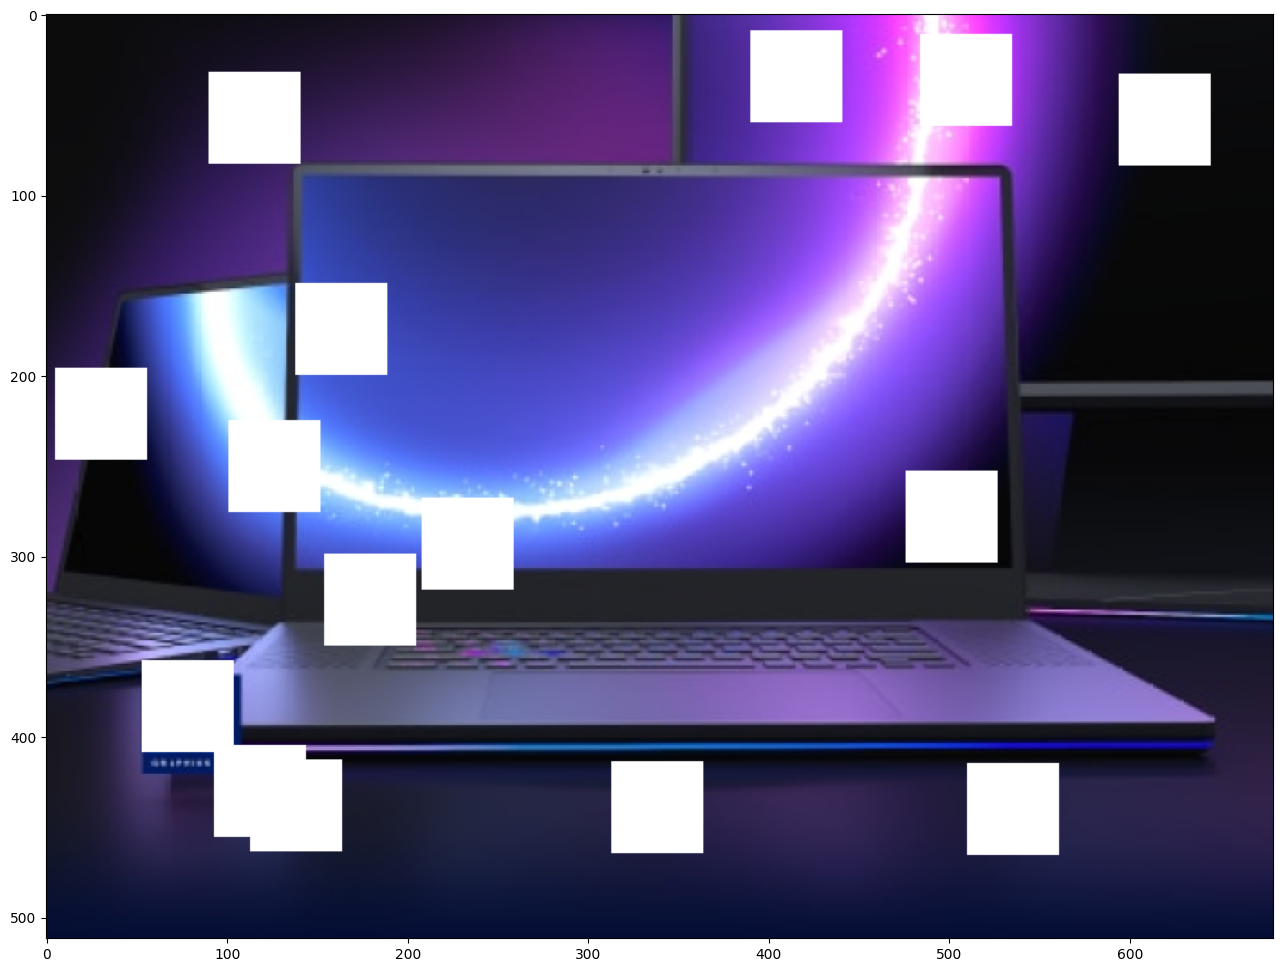

In [9]:
# Generating a masked image.
masked_image = (resized_image * (1 - mask) + 255 * mask).astype(np.uint8)
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB));

### Preprocessing

The model expects the input dimensions to be `NHWC`.

- masked_image.shape = (512,680,3) -----> model expects = (1,512,680,3)
- resized_mask.shape = (512,680,1) -----> model expects = (1,512,680,1)

In [10]:
masked_image = masked_image[None, ...]
mask = mask[None, ...]

### Inference

Do inference with the given masked image and the mask. Then, show the restored image.

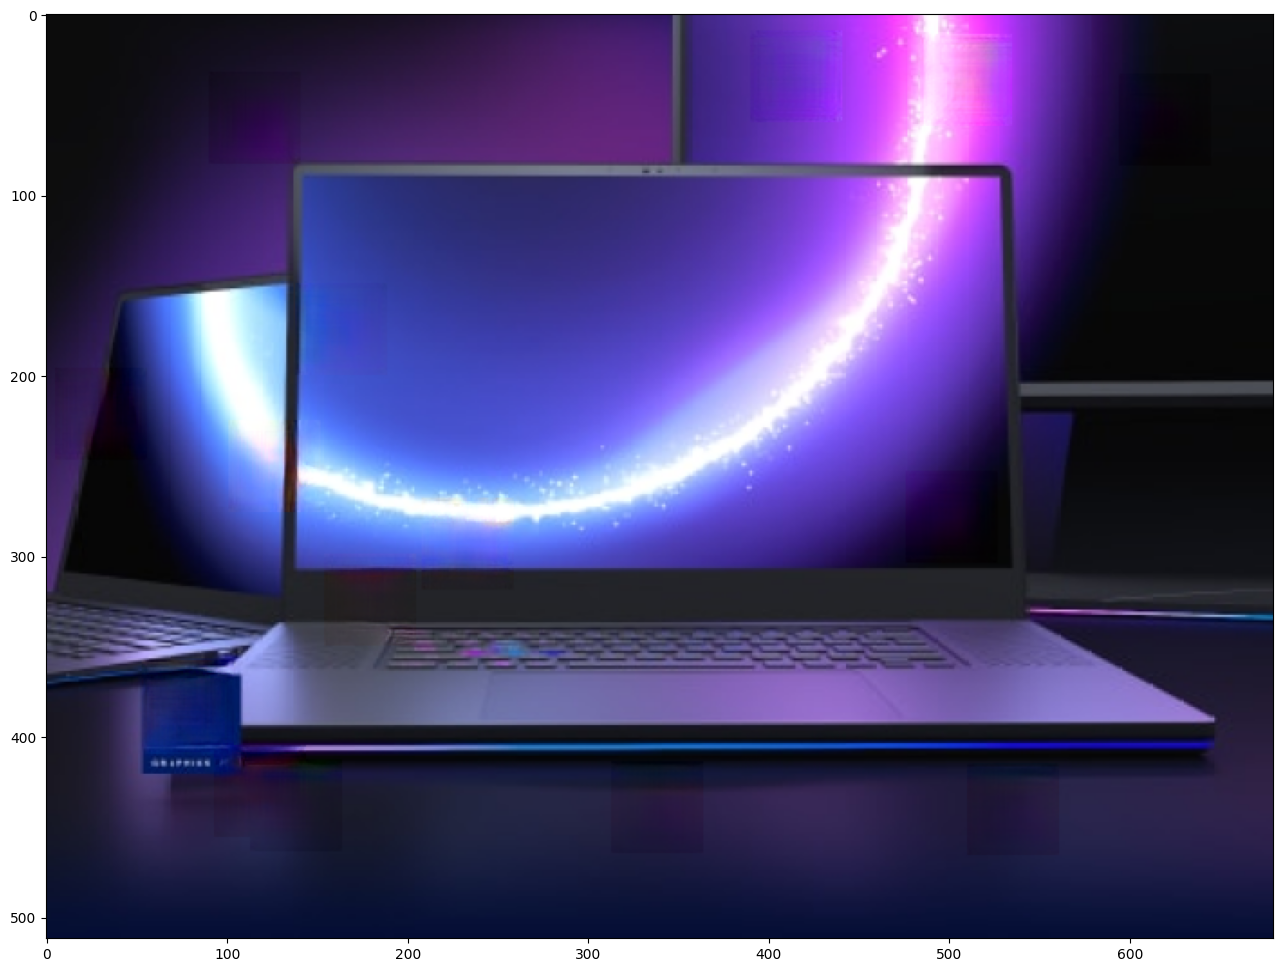

In [11]:
result = compiled_model([masked_image, mask])[output_layer]
result = result.squeeze().astype(np.uint8)
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

### Save the Restored Image

Save the restored image to the data directory to download it.

In [ ]:
cv2.imwrite("data/laptop_restored.png", result)